In [1]:
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#plt.style.use('ggplot')

In [2]:
#Process class - define the details of a process technology node.
# Cost values and defect densities are adapted and generalized from IC Knowledge (based on TSMC trend)
    #Assuming maximum number of metal layers available in a given process (high performance/density)
# Transistor densities are from WikiChip pages or IC Knowledge articles

class Process:
    def __init__(self, name, node, waferCost,defectDensity,tranDensity,diameter=300.0,streetWidth=0.075,edgeWidth=2.0,hasTsv=False):
        #Most units in mm. Node is in nm. Defect density is defects per mm^2. Tran density is MTx per mm^2. Cost is $.
        self.name = name;   # name - string - define the name of the process
        self.node = node;   # node - int - unit=nm - set the process node
        self.waferCost = waferCost;   # waferCost - float - unit=$ - cost per wafer
        if(hasTsv):  # hasTsv - bool - does process have TSVs added?
            self.waferCost = self.waferCost * 1.06;  # Wafer cost multiplier for additional TSV steps
        self.defectDensity = defectDensity; # defectDensity - float - unit=defects per mm^2 - average number of defects assuming Murphy yield model (Negative binomial with alpha=3) https://www.eesemi.com/test-yield-models.htm
        self.tranDensity = tranDensity; # tranDensity - float - unit=Million Transistors per mm^2 - process density metric based on NAND2 and scan flop densities: https://en.wikichip.org/wiki/mtr-mm%C2%B2
        self.diameter = diameter; # diameter - float - unit=mm - diameter of a wafer
        self.streetWidth = streetWidth; # streetWidth - float - unit=mm - spacer distance required between any two dies
        self.edgeWidth = edgeWidth; # edgeWidth - float - unit=mm - boundary around wafer edge where no dies will yield
        
    def print(self):
        print("Process:"+str(self.name)+",Node:"+str(self.node)+"nm,DefectDensity:"+str(self.defectDensity)+"per mm^2,Diameter:"+str(self.diameter)+"mm,StreetWidth:"+str(self.streetWidth)+"mm,EdgeExclusion:"+str(self.edgeWidth)+"mm,hasTsv:"+str(self.hasTsv))
    

In [3]:
#CMOS Process Technology Definitions

process5nm=Process(name="5nm FF",node=5,waferCost=11700.0,defectDensity=0.0005,tranDensity=173.1);
process7nm=Process(name="7nm FF+",node=7,waferCost=10300.0,defectDensity=0.00075,tranDensity=113.9);
process10nm=Process(name="10nm FF",node=10,waferCost=4100.0,defectDensity=0.00075,tranDensity=73.7);
process16nm=Process(name="16nm FF",node=16,waferCost=3000.0,defectDensity=0.0015,tranDensity=34.4);
process28nm=Process(name="28nm HPC",node=28,waferCost=2400.0,defectDensity=0.0025,tranDensity=19.5);
process40nm=Process(name="40nm G",node=40,waferCost=1900.0,defectDensity=0.0035,tranDensity=10.2);
process65nm=Process(name="65nm",node=65,waferCost=1500.0,defectDensity=0.0035,tranDensity=6.9); 

#Silicon Interposer with TSVs - assuming 4 layers from Assembly and Test Cost Price Model
processInterPos=Process(name="65nm Interposer TSV",node=65,waferCost=750,defectDensity=0.00005,tranDensity=0.0);
processInterPosNoTSV=Process(name="65nm Interposer No TSV",node=65,waferCost=600,defectDensity=0.00005,tranDensity=0.0);
processEMIB=Process(name="EMIB",node=2000,waferCost=200,defectDensity=0.0003,tranDensity=0.0); #Defect density selected to get 0.99 yield for 36 mm^2 bridge

#Active Interposer with TSVs - add TSV cost to CMOS processes
process5nmTsv=Process(name="5nm FF",node=5,waferCost=11700.0,defectDensity=0.0005,tranDensity=173.1,hasTsv=True);
process7nmTsv=Process(name="7nm FF+",node=7,waferCost=10300.0,defectDensity=0.00075,tranDensity=113.9,hasTsv=True);
process10nmTsv=Process(name="10nm FF",node=10,waferCost=4100.0,defectDensity=0.00075,tranDensity=73.7,hasTsv=True);
process16nmTsv=Process(name="16nm FF",node=16,waferCost=3000.0,defectDensity=0.0015,tranDensity=34.4,hasTsv=True);
process28nmTsv=Process(name="28nm HPC",node=28,waferCost=2400.0,defectDensity=0.0025,tranDensity=19.5,hasTsv=True);
process40nmTsv=Process(name="40nm G",node=40,waferCost=1900.0,defectDensity=0.0035,tranDensity=10.2,hasTsv=True);
process65nmTsv=Process(name="65nm",node=65,waferCost=1500.0,defectDensity=0.0035,tranDensity=6.9,hasTsv=True); 

In [4]:
#Chiplet class - define a single die with a given area and process technology
# can specify active area if only part of the chiplet is yield-critical (or if other areas have high yield or repair)

class Chiplet:
    def __init__(self,process,dieArea,name="chiplet default",activeArea=-1.0):
        self.process = process;   #Process class
        self.dieArea = dieArea;   #Float - unit=mm^2 - die area for dies per wafer
        self.name = name;         #String
        if(activeArea<0.0):
            self.activeArea=self.dieArea; # if no active area is defined, then assume entire die is active area
        else:
            self.activeArea=activeArea; #Float - unit=mm^2 - active transitor area for yield
        self.dieYield = self.calculateYield(self.activeArea, self.process); # 0.0 to 1.0
        self.diesPerWafer = self.calculateDiesPerWafer(self.dieArea, self.process); # Float - average number of dies per wafer
        self.dieCostBeforeYield = self.calculateDieCostBeforeYield(self.diesPerWafer,self.process); # Float - cost per die with 100% yield
        self.dieCost = self.calculateDieCost(self.diesPerWafer,self.dieYield,self.process); # Float - cost per die
        
    def calculateYield(self,activeArea,process):
        alpha = 3.0   # 3.0 = Murphy model
        dieYield = (1+((activeArea*process.defectDensity)/alpha))**(-1.0*alpha)  #Negative binomial yield model
        return dieYield
    
    def calculateDiesPerWafer(self,dieArea,process):
        #Includes loss from streetWidth between dies, and edge exclusion at boundary of wafer
        widthEst = dieArea**(0.5)   #approximating exclusion based on square die aspect ratio
        widthPlus = widthEst + (process.streetWidth/2.0)
        areaPlus = widthPlus**2
        diameterMinus = process.diameter - 2*process.edgeWidth
        numDie = (math.pi*((diameterMinus/2.0)**2.0))/areaPlus - (math.pi*diameterMinus)/((2.0*areaPlus)**0.5)
        return numDie
        
    def calculateDieCost(self,diesPerWafer,dieYield, process):
        dieCost = (process.waferCost/diesPerWafer) / dieYield
        return dieCost
    
    def calculateDieCostBeforeYield(self,diesPerWafer, process):
        dieCost = (process.waferCost/diesPerWafer)
        return dieCost
    

Test Area: 800.0
Active Int Active Area:  80.0
5nm , yield: 0.69 , diesPerWafer: 62.57 , dieCost: 272.19
7nm , yield: 0.58 , diesPerWafer: 62.57 , dieCost: 284.45
10nm , yield: 0.58 , diesPerWafer: 62.57 , dieCost: 113.23
16nm , yield: 0.36 , diesPerWafer: 62.57 , dieCost: 131.56
28nm , yield: 0.22 , diesPerWafer: 62.57 , dieCost: 177.57
40nm , yield: 0.14 , diesPerWafer: 62.57 , dieCost: 219.43
65nm , yield: 0.14 , diesPerWafer: 62.57 , dieCost: 173.23

IntPos , yield: 1.0 , diesPerWafer: 62.57 , dieCost: 11.99
IntPos NoTsv , yield: 1.0 , diesPerWafer: 62.57 , dieCost: 9.59
EMIB , yield: 0.79 , diesPerWafer: 62.57 , dieCost: 4.03

ActInt7 , yield: 0.94 , diesPerWafer: 62.57 , dieCost: 185.17
ActInt10 , yield: 0.94 , diesPerWafer: 62.57 , dieCost: 73.71
ActInt16 , yield: 0.89 , diesPerWafer: 62.57 , dieCost: 57.17
ActInt28 , yield: 0.82 , diesPerWafer: 62.57 , dieCost: 49.34
ActInt65 , yield: 0.77 , diesPerWafer: 62.57 , dieCost: 33.21



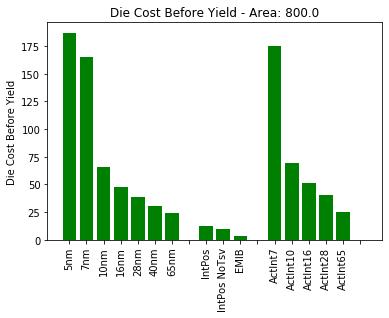

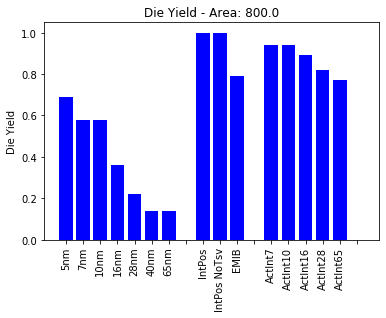

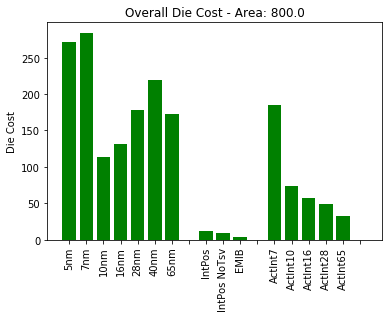

In [5]:
#Chiplet tests and cost exploration
testArea = 800.0
activeIntTestArea = testArea * 0.1


def printChipletDetails(chip):
    print(chip.name,", yield:",round(chip.dieYield,2),", diesPerWafer:",round(chip.diesPerWafer,2),", dieCost:",round(chip.dieCost,2));


tc5 = Chiplet(process5nm,testArea,"5nm");
tc7 = Chiplet(process7nm,testArea,"7nm");
tc10 = Chiplet(process10nm,testArea,"10nm");
tc16 = Chiplet(process16nm,testArea,"16nm");
tc28 = Chiplet(process28nm,testArea,"28nm");
tc40 = Chiplet(process40nm,testArea,"40nm");
tc65 = Chiplet(process65nm,testArea,"65nm");
intTest = Chiplet(processInterPos,testArea,"IntPos",1.0);
intTestNoTSV = Chiplet(processInterPosNoTSV,testArea,"IntPos NoTsv",1.0);
emibTest = Chiplet(processEMIB,testArea,"EMIB");
activeIntTest7 = Chiplet(process7nmTsv,testArea,"ActInt7",activeIntTestArea);
activeIntTest10 = Chiplet(process10nmTsv,testArea,"ActInt10",activeIntTestArea);
activeIntTest16 = Chiplet(process16nmTsv,testArea,"ActInt16",activeIntTestArea);
activeIntTest28 = Chiplet(process28nmTsv,testArea,"ActInt28",activeIntTestArea);
activeIntTest65 = Chiplet(process65nmTsv,testArea,"ActInt65",activeIntTestArea);


chipList1 = [tc5,tc7,tc10,tc16,tc28,tc40,tc65];
chipList2 = [intTest,intTestNoTSV,emibTest];
chipList3 = [activeIntTest7,activeIntTest10,activeIntTest16,activeIntTest28,activeIntTest65];
chipListOfLists = [chipList1,chipList2,chipList3]

labels = [];
yields = [];
costs = [];
costsBeforeYield = [];

print("Test Area:",testArea)
print("Active Int Active Area: ",activeIntTestArea)

for chipList in chipListOfLists:
    for chip in chipList:
        printChipletDetails(chip)
        labels.append(chip.name);
        yields.append(round(chip.dieYield,2))
        costs.append(round(chip.dieCost,2))
        costsBeforeYield.append(round(chip.dieCostBeforeYield,2))
    print("")
    labels.append("")
    yields.append(0)
    costs.append(0)
    costsBeforeYield.append(0)

plt.bar(range(len(costsBeforeYield)), costsBeforeYield, color='green')
plt.ylabel("Die Cost Before Yield")
plt.title("Die Cost Before Yield - Area: "+str(testArea))
plt.xticks(range(len(costsBeforeYield)), labels, rotation=90)
plt.show()

plt.bar(range(len(yields)), yields, color='blue')
plt.ylabel("Die Yield")
plt.title("Die Yield - Area: "+str(testArea))
plt.xticks(range(len(yields)), labels, rotation=90)
plt.show()

plt.bar(range(len(costs)), costs, color='green')
plt.ylabel("Die Cost")
plt.title("Overall Die Cost - Area: "+str(testArea))
plt.xticks(range(len(costs)), labels, rotation=90)
plt.show()
    


In [6]:
# Design class - calculate an area given a gate count and process
# Helper function to generate multiple chiplets
class Design:
    def __init__(self,process,gateCount,utilization=0.70):
        self.process = process;
        self.gateCount = gateCount;
        self.utilization = utilization;
        tranCount = self.gateCount * 4.0; #Assuming average of 4 transistors per gate
        self.area = ((tranCount/1000000.0)/process.tranDensity) / self.utilization;
        
    def createUniformChipletList(self, chipletCount, interfaceOverhead=0.0):
        chipletList = []
        areaPerChiplet = math.ceil(self.area/chipletCount) * (1.0+interfaceOverhead);
        for i in range(chipletCount):
            c = Chiplet(self.process,areaPerChiplet);
            chipletList.append(c);
        return chipletList
    

In [7]:
gateCountList = [1000000,10000000,100000000,1000000000,10000000000]
for gc in gateCountList:
    currDesign7 = Design(process7nm,gc)
    currDesign28 = Design(process28nm,gc)
    print("Gates:",gc/1000000,"M, 7nm Area:",currDesign7.area,"mm2, 28nm Area:",currDesign28.area,"mm2")

Gates: 1.0 M, 7nm Area: 0.05016932145992726 mm2, 28nm Area: 0.29304029304029305 mm2
Gates: 10.0 M, 7nm Area: 0.5016932145992725 mm2, 28nm Area: 2.93040293040293 mm2
Gates: 100.0 M, 7nm Area: 5.016932145992725 mm2, 28nm Area: 29.30402930402931 mm2
Gates: 1000.0 M, 7nm Area: 50.169321459927254 mm2, 28nm Area: 293.0402930402931 mm2
Gates: 10000.0 M, 7nm Area: 501.6932145992725 mm2, 28nm Area: 2930.4029304029305 mm2


1000000000.0
Gate Count: 1000000000.0
5nm , yield: 0.98 , diesPerWafer: 1943.88 , dieCost: 6.12
7nm , yield: 0.96 , diesPerWafer: 1264.87 , dieCost: 8.45
10nm , yield: 0.94 , diesPerWafer: 805.65 , dieCost: 5.39
16nm , yield: 0.79 , diesPerWafer: 360.99 , dieCost: 10.56
28nm , yield: 0.52 , diesPerWafer: 195.47 , dieCost: 23.65



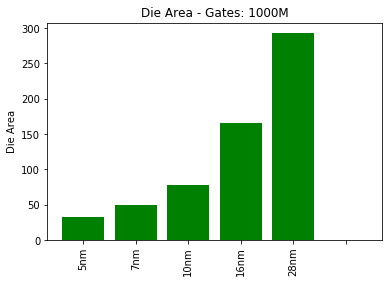

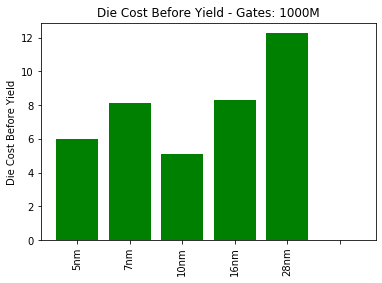

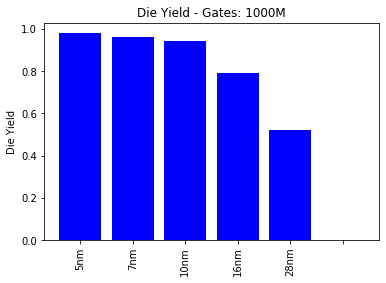

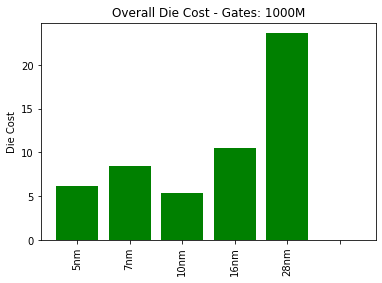

In [8]:
#Design Chiplet tests - 
gateCount = 1.0*float(10**9) 
print(gateCount)
activeIntTestArea = testArea * 0.1


def printChipletDetails(chip):
    print(chip.name,", yield:",round(chip.dieYield,2),", diesPerWafer:",round(chip.diesPerWafer,2),", dieCost:",round(chip.dieCost,2));


d5 = Design(process5nm,gateCount);
d7 = Design(process7nm,gateCount);
d10 = Design(process10nm,gateCount);
d16 = Design(process16nm,gateCount);
d28 = Design(process28nm,gateCount);
#d40 = Design(process40nm,gateCount);
#d65 = Design(process65nm,gateCount);

tc5 = Chiplet(process5nm,d5.area,"5nm");
tc7 = Chiplet(process7nm,d7.area,"7nm");
tc10 = Chiplet(process10nm,d10.area,"10nm");
tc16 = Chiplet(process16nm,d16.area,"16nm");
tc28 = Chiplet(process28nm,d28.area,"28nm");
#tc40 = Chiplet(process40nm,d40.area,"40nm");
#tc65 = Chiplet(process65nm,d65.area,"65nm");

chipList1 = [tc5,tc7,tc10,tc16,tc28];
#chipList2 = [intTest,intTestNoTSV,emibTest];
#chipList3 = [activeIntTest7,activeIntTest10,activeIntTest16,activeIntTest28,activeIntTest65];
#chipListOfLists = [chipList1,chipList2,chipList3]
chipListOfLists = [chipList1]

labels = [];
areas = [];
yields = [];
costs = [];
costsBeforeYield = [];

print("Gate Count:",gateCount)

for chipList in chipListOfLists:
    for chip in chipList:
        printChipletDetails(chip)
        labels.append(chip.name);
        areas.append(round(chip.dieArea,2))
        yields.append(round(chip.dieYield,2))
        costs.append(round(chip.dieCost,2))
        costsBeforeYield.append(round(chip.dieCostBeforeYield,2))
    print("")
    labels.append("")
    areas.append(0)
    yields.append(0)
    costs.append(0)
    costsBeforeYield.append(0)

plt.bar(range(len(areas)), areas, color='green')
plt.ylabel("Die Area")
plt.title("Die Area - Gates: "+str(int(gateCount/1000000))+"M")
plt.xticks(range(len(areas)), labels, rotation=90)
plt.show()
    
plt.bar(range(len(costsBeforeYield)), costsBeforeYield, color='green')
plt.ylabel("Die Cost Before Yield")
plt.title("Die Cost Before Yield - Gates: "+str(int(gateCount/1000000))+"M")
plt.xticks(range(len(costsBeforeYield)), labels, rotation=90)
plt.show()

plt.bar(range(len(yields)), yields, color='blue')
plt.ylabel("Die Yield")
plt.title("Die Yield - Gates: "+str(int(gateCount/1000000))+"M")
plt.xticks(range(len(yields)), labels, rotation=90)
plt.show()

plt.bar(range(len(costs)), costs, color='green')
plt.ylabel("Die Cost")
plt.title("Overall Die Cost - Gates: "+str(int(gateCount/1000000))+"M")
plt.xticks(range(len(costs)), labels, rotation=90)
plt.show()

In [9]:
#Yield test

alpha = 3.0
defectDensity = 0.0003
area = 36
dieYield = (1+((area*defectDensity)/alpha))**(-1.0*alpha)
print(dieYield)

0.9892772959467866


In [10]:
#Define a system with multiple 3D stacked chips

class Stack3D:
    def __init__(self,chipletList,bondYield=0.99):
        self.chipletList = chipletList;
        self.bondYield = bondYield;
        self.chipletCount = len(self.chipletList);
        bondingEvents = self.chipletCount - 1;
        #Assumption - KGD testing before stack-bonding. No intermediate bond testing.
        self.totalBondYield = self.bondYield ** bondingEvents;
        self.chipletCostSum = 0.0
        for c in chipletList:
            self.chipletCostSum = self.chipletCostSum + c.dieCost
        self.cost = self.chipletCostSum / self.totalBondYield
        self.integrationCost = self.cost-self.chipletCostSum

In [11]:
# Stack3D test
gateCount = 10**10

currProcess = process7nm

monoDesign = Design(currProcess,gateCount);
monoChiplet = Chiplet(currProcess,monoDesign.area)
print("chipletCount:",1,", gateCount:",gateCount);
print("areaPerChiplet:","{0:.1f}".format(monoChiplet.dieArea),", yieldPerChiplet:","{0:.3f}".format(monoChiplet.dieYield),", costPerChiplet:","{0:.2f}".format(monoChiplet.dieCost))
print("\n")

currProcess = process7nmTsv
interfaceOverhead=0.05

chipletCounts = [2,4,8]
for cc in chipletCounts:
    currDesign = Design(currProcess,gateCount)
    currChipList = currDesign.createUniformChipletList(cc,interfaceOverhead)
    areaPerChiplet = currChipList[0].dieArea
    costPerChiplet = currChipList[0].dieCost
    yieldPerChiplet = currChipList[0].dieYield
    currStack3D = Stack3D(currChipList,bondYield=0.99)
    print("chipletCount:",currStack3D.chipletCount,", gateCount:",gateCount);
    print("areaPerChiplet:","{0:.1f}".format(areaPerChiplet),", yieldPerChiplet:","{0:.3f}".format(yieldPerChiplet),", costPerChiplet:","{0:.2f}".format(costPerChiplet))
    print("totalBondYield:","{0:.3f}".format(currStack3D.totalBondYield),", chipletCostSum:","{0:.2f}".format(currStack3D.chipletCostSum),", stackCost:","{0:.2f}".format(currStack3D.cost))
    print("\n")

chipletCount: 1 , gateCount: 10000000000
areaPerChiplet: 501.7 , yieldPerChiplet: 0.702 , costPerChiplet: 136.71


chipletCount: 2 , gateCount: 10000000000
areaPerChiplet: 263.6 , yieldPerChiplet: 0.826 , costPerChiplet: 60.24
totalBondYield: 0.990 , chipletCostSum: 120.47 , stackCost: 121.69


chipletCount: 4 , gateCount: 10000000000
areaPerChiplet: 132.3 , yieldPerChiplet: 0.907 , costPerChiplet: 26.18
totalBondYield: 0.970 , chipletCostSum: 104.73 , stackCost: 107.93


chipletCount: 8 , gateCount: 10000000000
areaPerChiplet: 66.2 , yieldPerChiplet: 0.952 , costPerChiplet: 12.07
totalBondYield: 0.932 , chipletCostSum: 96.55 , stackCost: 103.59




In [12]:
#Define a system with multiple chiplets on a base interposer

class StackInterposer:
    def __init__(self,chipletList,interposerProcess,interposerAreaOverhead=0.0,interposerActiveArea=0.0,bondYield=0.99):
        self.chipletCount = len(chipletList);
        self.chipletList = chipletList;
        self.interposerProcess = interposerProcess;
        self.interposerActiveArea = interposerActiveArea;
        self.interposerAreaOverhead = interposerAreaOverhead;
        self.bondYield = bondYield;
        bondingEvents = self.chipletCount;
        #Assumption - KGD testing before interposer-bonding. No intermediate chiplet-interposer bond testing.
        self.totalBondYield = bondYield ** bondingEvents;
        self.chipletCostSum = 0.0
        self.chipletAreaSum = 0.0
        for c in chipletList:
            self.chipletCostSum = self.chipletCostSum + c.dieCost
            self.chipletAreaSum = self.chipletAreaSum + c.dieArea
        self.interposerArea = self.chipletAreaSum * (1.0 + interposerAreaOverhead);
        self.interposer = Chiplet(self.interposerProcess, self.interposerArea,"Interposer",self.interposerActiveArea);
        self.cost = self.interposer.dieCost + (self.chipletCostSum / self.totalBondYield)
        self.integrationCost = self.cost-self.chipletCostSum

In [13]:
# StackInterposer Passive test
gateCount = 1.6*10**10
currProcess = process7nm

monoDesign = Design(currProcess,gateCount);
monoChiplet = Chiplet(currProcess,monoDesign.area)
print("chipletCount:",1,", gateCount:",gateCount);
print("areaPerChiplet:","{0:.1f}".format(monoChiplet.dieArea),", yieldPerChiplet:","{0:.3f}".format(monoChiplet.dieYield),", costPerChiplet:","{0:.2f}".format(monoChiplet.dieCost))
print("\n")

    
chipletCounts = [2,4,8]
interfaceOverhead=0.05
    
for cc in chipletCounts:
    currDesign = Design(currProcess,gateCount)
    currChipList = currDesign.createUniformChipletList(cc,interfaceOverhead)
    areaPerChiplet = currChipList[0].dieArea
    costPerChiplet = currChipList[0].dieCost
    yieldPerChiplet = currChipList[0].dieYield
    currStackInterposer = StackInterposer(currChipList,processInterPos,interposerAreaOverhead=0.25,bondYield=0.99);
    currInt = currStackInterposer.interposer;
    intArea = currInt.dieArea
    intYield = currInt.dieYield
    intCost = currInt.dieCost
    print("chipletCount:",currStackInterposer.chipletCount,", gateCount:",gateCount);
    print("areaPerChiplet:","{0:.1f}".format(areaPerChiplet),", yieldPerChiplet:","{0:.3f}".format(yieldPerChiplet),", costPerChiplet:","{0:.2f}".format(costPerChiplet))
    print("interposerArea:","{0:.1f}".format(intArea),", interposerYield:","{0:.3f}".format(intYield),", interposerCost:","{0:.2f}".format(intCost))
    print("totalBondYield:","{0:.3f}".format(currStackInterposer.totalBondYield),", chipletCostSum:","{0:.2f}".format(currStackInterposer.chipletCostSum),", stackCost:","{0:.2f}".format(currStackInterposer.cost))
    print("\n")
    


chipletCount: 1 , gateCount: 16000000000.0
areaPerChiplet: 802.7 , yieldPerChiplet: 0.578 , costPerChiplet: 286.07


chipletCount: 2 , gateCount: 16000000000.0
areaPerChiplet: 422.1 , yieldPerChiplet: 0.740 , costPerChiplet: 106.65
interposerArea: 1055.2 , interposerYield: 1.000 , interposerCost: 16.73
totalBondYield: 0.980 , chipletCostSum: 213.31 , stackCost: 234.37


chipletCount: 4 , gateCount: 16000000000.0
areaPerChiplet: 211.1 , yieldPerChiplet: 0.857 , costPerChiplet: 43.04
interposerArea: 1055.2 , interposerYield: 1.000 , interposerCost: 16.73
totalBondYield: 0.961 , chipletCostSum: 172.16 , stackCost: 195.94


chipletCount: 8 , gateCount: 16000000000.0
areaPerChiplet: 106.1 , yieldPerChiplet: 0.925 , costPerChiplet: 19.19
interposerArea: 1060.5 , interposerYield: 1.000 , interposerCost: 16.83
totalBondYield: 0.923 , chipletCostSum: 153.52 , stackCost: 183.20




In [14]:
# StackInterposer Active test
gateCount = 1.6*10**10
currProcess = process7nm
chipletCount = 8
interfaceOverhead = 0.05

monoDesign = Design(currProcess,gateCount);
monoChiplet = Chiplet(currProcess,monoDesign.area)
print("chipletCount:",1,", gateCount:",gateCount);
print("areaPerChiplet:","{0:.1f}".format(monoChiplet.dieArea),", yieldPerChiplet:","{0:.3f}".format(monoChiplet.dieYield),", costPerChiplet:","{0:.2f}".format(monoChiplet.dieCost))
print("\n")

currDesign = Design(currProcess,gateCount)
currChipList = currDesign.createUniformChipletList(chipletCount,interfaceOverhead)
areaPerChiplet = currChipList[0].dieArea
costPerChiplet = currChipList[0].dieCost
yieldPerChiplet = currChipList[0].dieYield

intProcs = [process7nmTsv,process10nmTsv,process16nmTsv,process28nmTsv]
for ip in intProcs:
    currStackInterposer = StackInterposer(currChipList,ip,interposerAreaOverhead=0.25,bondYield=0.99,interposerActiveArea=100.0);
    currInt = currStackInterposer.interposer;
    intArea = currInt.dieArea
    intYield = currInt.dieYield
    intCost = currInt.dieCost
    print("interposerProcess:",ip.name)
    print("chipletCount:",currStackInterposer.chipletCount,", gateCount:",gateCount);
    print("areaPerChiplet:","{0:.1f}".format(areaPerChiplet),", yieldPerChiplet:","{0:.3f}".format(yieldPerChiplet),", costPerChiplet:","{0:.2f}".format(costPerChiplet))
    print("interposerArea:","{0:.1f}".format(intArea),", interposerYield:","{0:.3f}".format(intYield),", interposerCost:","{0:.2f}".format(intCost))
    print("totalBondYield:","{0:.3f}".format(currStackInterposer.totalBondYield),", chipletCostSum:","{0:.2f}".format(currStackInterposer.chipletCostSum),", stackCost:","{0:.2f}".format(currStackInterposer.cost))
    print("\n")
    


chipletCount: 1 , gateCount: 16000000000.0
areaPerChiplet: 802.7 , yieldPerChiplet: 0.578 , costPerChiplet: 286.07


interposerProcess: 7nm FF+
chipletCount: 8 , gateCount: 16000000000.0
areaPerChiplet: 106.1 , yieldPerChiplet: 0.925 , costPerChiplet: 19.19
interposerArea: 1060.5 , interposerYield: 0.929 , interposerCost: 263.80
totalBondYield: 0.923 , chipletCostSum: 153.52 , stackCost: 430.17


interposerProcess: 10nm FF
chipletCount: 8 , gateCount: 16000000000.0
areaPerChiplet: 106.1 , yieldPerChiplet: 0.925 , costPerChiplet: 19.19
interposerArea: 1060.5 , interposerYield: 0.929 , interposerCost: 105.01
totalBondYield: 0.923 , chipletCostSum: 153.52 , stackCost: 271.38


interposerProcess: 16nm FF
chipletCount: 8 , gateCount: 16000000000.0
areaPerChiplet: 106.1 , yieldPerChiplet: 0.925 , costPerChiplet: 19.19
interposerArea: 1060.5 , interposerYield: 0.864 , interposerCost: 82.59
totalBondYield: 0.923 , chipletCostSum: 153.52 , stackCost: 248.97


interposerProcess: 28nm HPC
chiplet